In [1]:
import os
from skimage.color import rgb2lab, lab2rgb
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch_directml
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor

%matplotlib inline

In [2]:
class ImageColorizerDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=1281167, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = read_image(image_path).permute(1, 2, 0).numpy() / 255.0
        lab_img = rgb2lab(rgb_img)
        
        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float(), ab.float()

In [3]:
batch_size = 256

train_data = ImageColorizerDataset(root_dir="./data", train=True, transform=ToTensor(), target_transform=ToTensor(), n_samples=10000)
test_data = ImageColorizerDataset(root_dir="./data", train=False, transform=ToTensor(), target_transform=ToTensor(), n_samples=1000)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

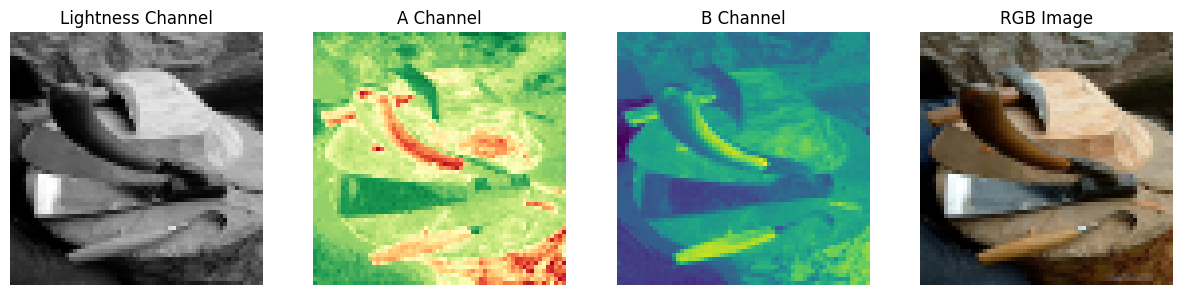

In [4]:
l, ab = next(iter(train_dataloader))

rgb_mean = read_image(os.path.join("./data", "mean.png")).permute(1, 2, 0).numpy() / 255.0
rgb_stdev = read_image(os.path.join("./data", "stdev.png")).permute(1, 2, 0).numpy() / 255.0

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(l[0].squeeze(), cmap="gray")
ax[0].set_title("Lightness Channel")
ax[0].set_axis_off()

ax[1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[1].set_title("A Channel")
ax[1].set_axis_off()

ax[2].imshow(ab[0, 1])
ax[2].set_title("B Channel")
ax[2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
lab = lab2rgb(lab)

ax[3].imshow(lab, interpolation=None)
ax[3].set_title("RGB Image")
ax[3].set_axis_off()

In [5]:
device = torch_directml.device()
print(f"Using {device} device")

Using privateuseone:0 device


In [6]:
from torchinfo import summary

class ImageColorizerNetwork(nn.Module):
    def __init__(self):
        """Convolutional neural network for colorizing grayscale images in LAB space.
        Takes a 1x64x64 image as input and outputs a 2x64x64 image.
        """
        super().__init__()

        self.conv_input = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv_output = nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1)
        
        self.conv64_64 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv128_128 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv256_256 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv512_512 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv1024_1024 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)

        self.conv64_128 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv128_256 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv256_512 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv512_1024 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)

        self.conv1024_512 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv512_256 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv256_128 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv128_64 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.encoder3 = nn.Sequential(
            self.conv128_256,
            self.batchnorm256,
            nn.ReLU(),
            self.conv256_256,
            self.batchnorm256,
            nn.ReLU(),
            self.conv256_256,
            self.batchnorm256,
            nn.ReLU(),
        )

        self.encoder4 = nn.Sequential(
            self.conv256_512,
            self.batchnorm512,
            nn.ReLU(),
            self.conv512_512,
            self.batchnorm512,
            nn.ReLU(),
            self.conv512_512,
            self.batchnorm512,
            nn.ReLU(),
        )

        self.encoder5 = nn.Sequential(
            self.conv512_1024,
            self.batchnorm1024,
            nn.ReLU(),
            self.conv1024_1024,
            self.batchnorm1024,
            nn.ReLU(),
            self.conv1024_1024,
            self.batchnorm1024,
            nn.ReLU(),
        )

        self.decoder1 = nn.Sequential(
            self.conv1024_512,
            self.batchnorm512,
            nn.ReLU(),
            self.conv512_512,
            self.batchnorm512,
            nn.ReLU(),
            self.conv512_512,
            self.batchnorm512,
            nn.ReLU(),
        )

        self.decoder2 = nn.Sequential(
            self.conv512_256,
            self.batchnorm256,
            nn.ReLU(),
            self.conv256_256,
            self.batchnorm256,
            nn.ReLU(),
            self.conv256_256,
            self.batchnorm256,
            nn.ReLU(),
        )

        self.decoder3 = nn.Sequential(
            self.conv256_128,
            self.batchnorm128,
            nn.ReLU(),
            self.conv128_128,
            self.batchnorm128,
            nn.ReLU(),
            self.conv128_128,
            self.batchnorm128,
            nn.ReLU(),
        )

        self.decoder4 = nn.Sequential(
            self.conv128_64,
            self.batchnorm64,
            nn.ReLU(),
            self.conv64_64,
            self.batchnorm64,
            nn.ReLU(),
            self.conv64_64,
            self.batchnorm64,
            nn.ReLU(),
            self.conv_output,
            nn.Tanh(),
        )

        
    
    def forward(self, x):
        x = self.encoder1(x)
        x, indices1 = self.maxpool(x)

        x = self.encoder2(x)
        x, indices2 = self.maxpool(x)

        x = self.encoder3(x)
        x, indices3 = self.maxpool(x)

        x = self.encoder4(x)
        x, indices4 = self.maxpool(x)

        x = self.encoder5(x)
        x, indices5 = self.maxpool(x)

        x = self.maxunpool(x, indices5)
        x = self.decoder1(x)

        x = self.maxunpool(x, indices4)
        x = self.decoder2(x)
        
        x = self.maxunpool(x, indices3)
        x = self.decoder3(x)

        x = self.maxunpool(x, indices2)
        x = self.decoder4(x)

        return x


model = ImageColorizerNetwork()
summary(model, input_size=(batch_size, 1, 64, 64), col_names=["input_size", "output_size", "kernel_size", "num_params"], row_settings=["var_names"])

torch.Size([256, 1, 64, 64])
torch.Size([256, 64, 32, 32])
torch.Size([256, 128, 16, 16])
torch.Size([256, 256, 8, 8])
torch.Size([256, 512, 4, 4])
torch.Size([256, 1024, 2, 2])
torch.Size([256, 512, 4, 4])
torch.Size([256, 256, 8, 8])
torch.Size([256, 128, 16, 16])
torch.Size([256, 2, 32, 32])


Layer (type (var_name))                            Input Shape               Output Shape              Kernel Shape              Param #
ImageColorizerNetwork (ImageColorizerNetwork)      [256, 1, 64, 64]          [256, 2, 32, 32]          --                        --
├─Sequential (encoder1)                            [256, 1, 64, 64]          [256, 64, 64, 64]         --                        37,056
│    └─Conv2d (0)                                  [256, 1, 64, 64]          [256, 64, 64, 64]         [3, 3]                    640
├─Sequential (decoder4)                            --                        --                        --                        (recursive)
│    └─BatchNorm2d (7)                             [256, 64, 64, 64]         [256, 64, 64, 64]         --                        128
│    └─ReLU (8)                                    [256, 64, 64, 64]         [256, 64, 64, 64]         --                        --
│    └─Conv2d (6)                                  [256,

In [7]:
from tqdm import tqdm

model = model.to(device)

learning_rate = 1e-3
weight_decay = 2e-5
epochs = 128
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


def train(dataloader, model, loss_fn, optimizer, epoch, total_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with tqdm(dataloader, total=num_batches, bar_format="{l_bar}{bar:25}{r_bar}{bar:-25b}", desc=f"Train {epoch}/{total_epochs}", leave=False) as train_pbar:
        for l, ab in train_pbar:
            l, ab = l.to(device), ab.to(device)

            # Compute prediction error
            pred_ab = model(l)
            loss = loss_fn(pred_ab, ab)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            train_pbar.set_postfix(loss=train_loss / num_batches)
            
    return train_loss / num_batches

def test(dataloader, model, loss_fn, epoch, total_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        with tqdm(dataloader, bar_format="{l_bar}{bar:25}{r_bar}{bar:-25b}", desc=f"Test {epoch}/{total_epochs}", leave=False) as test_pbar:
            for l, ab in test_pbar:
                l, ab = l.to(device), ab.to(device)
                pred = model(l)
                test_loss += loss_fn(pred, ab).item()

                test_pbar.set_postfix(loss=test_loss / num_batches)

    return test_loss / num_batches

In [8]:
# wandb.init(project="image-colorizer", config={
#     "learning_rate": learning_rate,
#     "architecture": "CNN",
#     "batch_size": batch_size,
#     "epochs": epochs,
#     "loss_fn": "MSELoss",
#     "dataset": "MIRFLICKR-25k-thumbs"
# })
from tqdm import tqdm


train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)


for e in range(epochs):
    train_losses[e] = train(train_dataloader, model, loss_fn, optimizer, e, epochs)
    test_losses[e] = test(test_dataloader, model, loss_fn, e, epochs)

print("Done!")

Train 0/128:   0%|                         | 0/40 [00:00<?, ?it/s]

torch.Size([256, 1, 64, 64])
torch.Size([256, 64, 32, 32])


KeyboardInterrupt: 

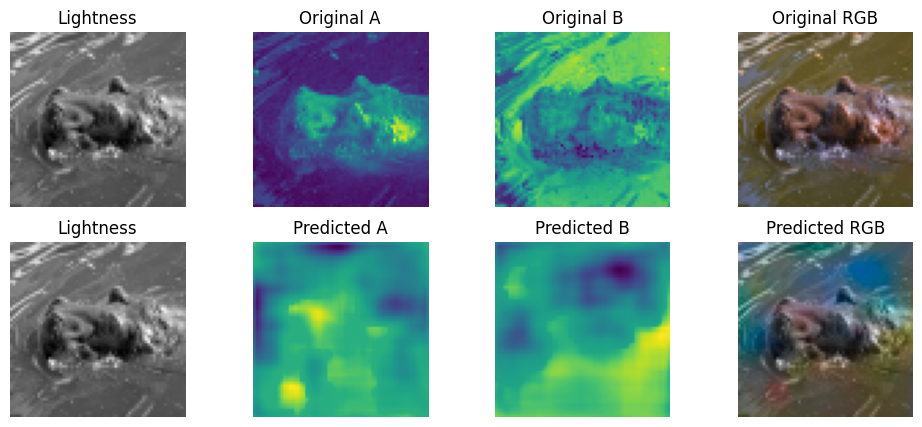

In [ ]:
l, ab = next(iter(test_dataloader))
fig, ax = plt.subplots(2, 4, figsize=(12, 5))

# first row: lightness, original A, original B, original RGB image
ax[0, 0].imshow(l[0, 0, :, :], cmap="gray")
ax[0, 1].imshow(ab[0, 0, :, :])
ax[0, 2].imshow(ab[0, 1, :, :])
ax[0, 3].imshow(lab2rgb(np.concatenate((l[0, 0, :, :].unsqueeze(0), ab[0, :, :, :]), axis=0).transpose(1, 2, 0)))

# second row: lightness, predicted A, predicted B, predicted RGB image
pred_ab = model(l.to(device))
ax[1, 0].imshow(l[0, 0, :, :], cmap="gray")
ax[1, 1].imshow(pred_ab[0, 0, :, :].cpu().detach())
ax[1, 2].imshow(pred_ab[0, 1, :, :].cpu().detach())
ax[1, 3].imshow(lab2rgb(np.concatenate((l[0, 0, :, :].unsqueeze(0), pred_ab[0, :, :, :].cpu().detach()), axis=0).transpose(1, 2, 0)))

# title everything
ax[0, 0].set_title("Lightness")
ax[0, 1].set_title("Original A")
ax[0, 2].set_title("Original B")
ax[0, 3].set_title("Original RGB")
ax[1, 0].set_title("Lightness")
ax[1, 1].set_title("Predicted A")
ax[1, 2].set_title("Predicted B")
ax[1, 3].set_title("Predicted RGB")

# remove axes
for i in range(2):
    for j in range(4):
        ax[i, j].axis("off")

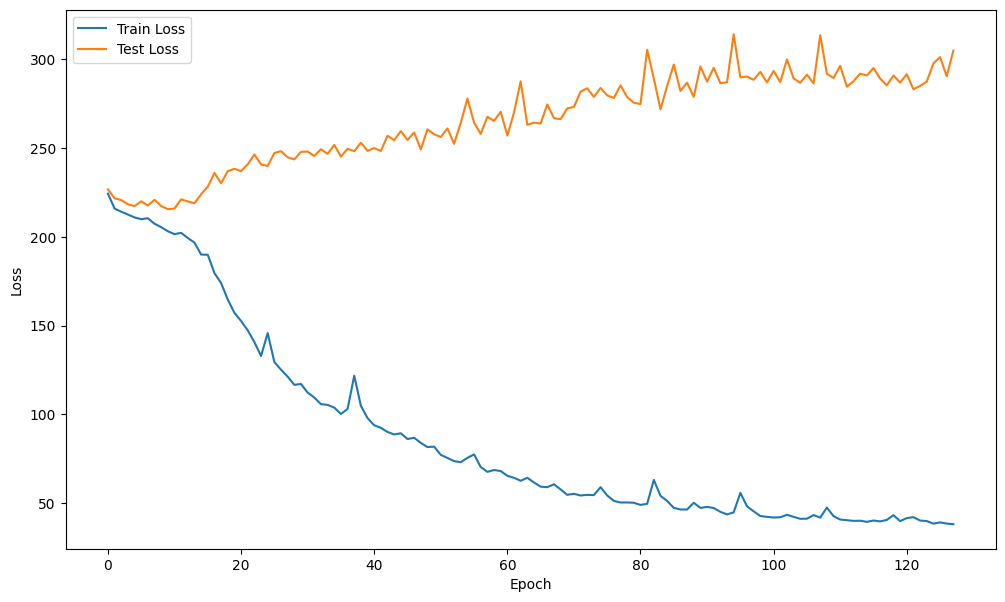

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(train_losses, label="Train Loss")
ax.plot(test_losses, label="Test Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
torch.save(model, "model.pt")
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy", test_losses)